In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
from access.profiling.access_models import ACCESSOM3Profiling
from access.config.accessom3_layout_input import OM3LayoutSearchConfig


In [3]:
repository_url = "https://github.com/ACCESS-NRI/access-om3-configs.git"
start_point = "e8f7559"
test_path = Path("/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings")
repository_directory = "Scaling_MC-100km-ryf-10days"
branch_name_prefix = "MC-100km-ryf-10days"

work_dir = test_path / repository_directory
archive_dir = test_path / "archive" / repository_directory

cores_per_node = 104
blocks_per_node = 8

node_count = 5
node_list = list(range(1, node_count + 1))


pool_map = {
    "atm": "shared",
    "cpl": "shared",
    "ice": "shared",
    "rof": "shared",
    "ocn": "ocn",
}

pool_order = ["shared", "ocn"]

max_ratio_to_baseline = [
    *([{"ocn": 15.0}] * node_count),
]

min_ratio_to_baseline = [
    {"ocn": 1.0},
    *([{"ocn": 2.0}] * (node_count - 1)),
]

min_blocks={"shared": 1, "ocn": 1}

control_options = {
    "config.yaml": {
        "metadata": {"enable": True}
    }
}

clock_attributes = {
    "restart_n": 10,
    "restart_option": "ndays",
    "stop_n": 10,
    "stop_option": "ndays",
}

walltime_hrs = 5  # same for all node counts

In [4]:
def layout_search_config_builder(num_nodes: float) -> OM3LayoutSearchConfig:
    """
    Build per-node om3 layout search settings.
    """
    n = int(num_nodes)
    i = node_list.index(n)

    return OM3LayoutSearchConfig(
        scheduler="pbs",
        queue="normalsr",
        pool_map=pool_map,
        pool_order=pool_order,
        blocks_per_node=blocks_per_node,
        baseline_pool_name="shared",
        eps=1e-6,
        max_ratio_to_baseline=max_ratio_to_baseline[i],
        min_ratio_to_baseline=min_ratio_to_baseline[i],
        min_blocks=min_blocks,
        enable_esmf_trace=True,
        trace_pets=None,  # inject petlists per-layout in overrides
    )

def walltime(walltime_hrs: float) -> float:
    return walltime_hrs

def block_overrides_builder(layout, num_nodes: float) -> dict:
    """
    Build per-layout block overrides.
    """
    _ = num_nodes
    ocn_rootpe = layout.pool_rootpe["ocn"]
    return {
        "MOM_input": {
            "AUTO_MASKTABLE": "REMOVE",
        },
        "nuopc.runconfig": {
            "CLOCK_attributes": clock_attributes,
        },
        "config.yaml": {
            "env": {
                "ESMF_RUNTIME_PROFILE_OUTPUT": "SUMMARY",
                "ESMF_RUNTIME_TRACE_PETLIST": f"0 {ocn_rootpe}",
            }
        },
    }

In [5]:
# Instantiate the om3 manager
om3_manager = ACCESSOM3Profiling(work_dir=test_path, archive_dir=archive_dir)

# set control experiment base
om3_manager.set_control(repository_url, start_point)

# set repository_directory
om3_manager._repository_directory = repository_directory

# set nruns
om3_manager._nruns = 1

# startfrom_restart
om3_manager._startfrom_restart = "cold"

# generate perturbation experiments
om3_manager.generate_scaling_experiments(
    num_nodes_list=node_list,
    control_options=control_options,
    cores_per_node=cores_per_node,
    branch_name_prefix=branch_name_prefix,
    walltime=walltime,
    layout_search_config_builder=layout_search_config_builder,
    block_overrides_builder=block_overrides_builder,
)


-- Test directory /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings already exists!
-- Test dir: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-100km-ryf-10days already exists, hence not cloning https://github.com/ACCESS-NRI/access-om3-configs.git
Checked out branch: ctrl
laboratory path:  /scratch/tm70/ml0072/access-om3
binary path:  /scratch/tm70/ml0072/access-om3/bin
input path:  /scratch/tm70/ml0072/access-om3/input
work path:  /scratch/tm70/ml0072/access-om3/work
archive path:  /scratch/tm70/ml0072/access-om3/archive
Found experiment archive: /scratch/tm70/ml0072/access-om3/archive/Scaling_MC-100km-ryf-10days-ctrl-afce2429
Removed archive symlink to /scratch/tm70/ml0072/access-om3/archive/Scaling_MC-100km-ryf-10days-MC-100km-ryf-10days_node_5_queue_normalsr_shared_169_ocn_351-db3a957c
Added archive symlink to /scratch/tm70/ml0072/acc

In [6]:
# run experiments
om3_manager.run_experiments()

* Current Branch: MC-100km-ryf-10days_node_5_queue_normalsr_shared_169_ocn_351
    experiment_uuid: db3a957c-3138-4886-8988-e14bc10ee249
Branch: MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91
    experiment_uuid: b8c4ae20-a1b8-4703-9ffd-588b297b1e08
Branch: MC-100km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78
    experiment_uuid: e42e8886-1cac-4236-a8f2-145c85c1afb4
Branch: MC-100km-ryf-10days_node_1_queue_normalsr_shared_39_ocn_65
    experiment_uuid: be17bdbb-0f9a-464f-9762-77eb201a70cd
Branch: MC-100km-ryf-10days_node_1_queue_normalsr_shared_52_ocn_52
    experiment_uuid: 2f39edca-5e26-4547-9cd1-3ba9b4b89b5a
Branch: MC-100km-ryf-10days_node_2_queue_normalsr_shared_13_ocn_195
    experiment_uuid: 30d6eec6-5813-480c-a69c-10572e12bb06
Branch: MC-100km-ryf-10days_node_2_queue_normalsr_shared_26_ocn_182
    experiment_uuid: 858ed666-f45f-4aac-9da8-08642558e299
Branch: MC-100km-ryf-10days_node_2_queue_normalsr_shared_39_ocn_169
    experiment_uuid: 921059be-53ec-42d2-b2d

In [7]:
# accessom3_profiling.purge_experiments(dry_run=False, hard=True, remove_repo_dir=True)

In [8]:
import re
from access.esmf_trace import run_from_config, post_summary_from_config
from access.esmf_trace.tmp_yaml_parser import read_yaml, write_yaml
from access.esmf_trace.library import ACCESSRunConfigBuilder, ACCESSPostSummaryConfigBuilder

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

In [9]:
om3_manager._repository_directory

'Scaling_MC-100km-ryf-10days'

In [10]:
dir(om3_manager)


['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_control_commit',
 '_nruns',
 '_repository',
 '_repository_directory',
 '_startfrom_restart',
 'add_experiment_from_directory',
 'archive_dir',
 'archive_experiments',
 'data',
 'delete_experiment',
 'experiments',
 'generate_core_layouts_from_node_count',
 'generate_perturbation_block',
 'generate_scaling_experiments',
 'get_component_logs',
 'layout_key',
 'model_type',
 'nruns',
 'parse_ncpus',
 'parse_profiling_data',
 'plot_scaling_data',
 'profiling_logs',
 'run_experiments',
 'set_control',
 'startfrom_restart',
 'work_dir']

In [11]:
om3_manager.work_dir

PosixPath('/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings')

In [12]:
branches = list(om3_manager.experiments.keys())
repository_directory = om3_manager._repository_directory
work_dir = om3_manager.work_dir
count=len(branches)
postprocess_prefix = "postprocessing"
post_base_path = work_dir / f"{postprocess_prefix}_{repository_directory}"
exact_paths = paths = [exp.path / "archive" for exp in om3_manager.experiments.values()]

model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
]

branch_pattern = re.compile(
    r"_node_(?P<node>\d+)_.*?_shared_(?P<shared>\d+)_ocn_(?P<ocn>\d+)"
)

builder = ACCESSRunConfigBuilder(
    branches=branches,
    post_base_path=post_base_path,
    exact_paths=exact_paths,
    model_component=model_component,
    branch_pattern=branch_pattern,
    pets_components=["shared"],
    max_workers=8,
)
cfg_run = builder.build_config()

In [13]:
cfg_run

{'default_settings': {'post_base_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/postprocessing_Scaling_MC-100km-ryf-10days',
  'model_component': ['[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1',
   '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1'],
  'stream_prefix': 'esmf_stream',
  'xaxis_datetime': False,
  'separate_plots': False,
  'cmap': 'tab10',
  'renderer': 'browser',
  'show_html': False,
  'max_workers': 8},
 'runs': [{'exact_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/Scaling_MC-100km-ryf-10days/archive',
   'base_prefix': 'MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91',
   'pets': '0,13'},
  {'exact_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new

In [14]:
run_from_config(cfg_run)

-- Using up to 8 parallel workers
-- skip postprocessing, expected outputs already exist in postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/output000
-- skip postprocessing, expected outputs already exist in postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78/output000
-- skip postprocessing, expected outputs already exist in postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_39_ocn_65/output000
-- skip postprocessing, expected outputs already exist in postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_52_ocn_52/output000
-- skip postprocessing, expected outputs already exist in postprocessing_MC-100km-ryf-10days_node_2_queue_normalsr_shared_13_ocn_195/output000
-- skip postprocessing, expected outputs already exist in postprocessing_MC-100km-ryf-10days_node_2_queue_normalsr_shared_26_ocn_182/output000
-- skip postprocessing, expected outputs already exist in postprocessing_MC-100km-ryf-10days_node_2_queue_normal

In [15]:
save_json_path = post_base_path / "post_summary_config.json"
builder = ACCESSPostSummaryConfigBuilder(
    post_base_path=post_base_path,
    model_component=model_component,
    stats_start_index=2,
    stats_end_index=-1,
    save_json_path=save_json_path,
)

In [16]:
def parse_pets(pets):
    if pets is None:
        return None
    if isinstance(pets, (list, tuple, set)):
        return [int(p) for p in pets]
    
    # assume string like "0,13"
    return [int(p.strip()) for p in pets.split(",") if p.strip()]

runs = [
    {
        "name": postprocess_prefix+"_"+r["base_prefix"],
        "pets": parse_pets(r["pets"]),
    } for r in cfg_run["runs"]
    ]

cfg_summary = builder.build_config(runs=runs)
print(cfg_summary)

{'default_settings': {'post_base_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/postprocessing_Scaling_MC-100km-ryf-10days', 'timeseries_suffix': '_timeseries.json', 'model_component': ['[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1', '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1'], 'stats_start_index': 2, 'stats_end_index': -1, 'save_json_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/postprocessing_Scaling_MC-100km-ryf-10days/post_summary_config.json'}, 'runs': [{'name': 'postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91', 'pets': [0, 13]}, {'name': 'postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78', 'pets': [0, 26]}, {'name': 'postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_39_ocn_65', 'pets': [0, 39]}, {'name': 'postpro

In [17]:
post_summary_from_config(cfg_summary)



-- Summary table:
                                                     hits      tmin  \
name                                                                  
postprocessing_MC-100km-ryf-10days_node_1_queue...  480.0  0.000899   
postprocessing_MC-100km-ryf-10days_node_1_queue...  240.0  0.000501   
postprocessing_MC-100km-ryf-10days_node_1_queue...  480.0  0.000899   
postprocessing_MC-100km-ryf-10days_node_1_queue...  240.0  0.000501   
postprocessing_MC-100km-ryf-10days_node_1_queue...  480.0  0.000432   
...                                                   ...       ...   
postprocessing_MC-100km-ryf-10days_node_5_queue...  240.0  0.000470   
postprocessing_MC-100km-ryf-10days_node_5_queue...  480.0  0.000198   
postprocessing_MC-100km-ryf-10days_node_5_queue...  240.0  0.002380   
postprocessing_MC-100km-ryf-10days_node_5_queue...  480.0  0.000198   
postprocessing_MC-100km-ryf-10days_node_5_queue...  240.0  0.002380   

                                                        

In [18]:
parquet_path = test_path / f"{postprocess_prefix}_{repository_directory}" / "post_summary_config_table.parquet"
df = pd.read_parquet(parquet_path)
df

,hits,tmin,tmax,tavg,tmedian,tstd,pemin,pemax
name,,,,,,,,
postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,480.0,0.000899,0.650235,0.008096,0.007382,0.030077,0,13
postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,240.0,0.000501,14.695145,1.171850,1.107257,0.960035,13,13
postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,480.0,0.000899,0.650235,0.008096,0.007382,0.030077,0,13
postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,240.0,0.000501,14.695145,1.171850,1.107257,0.960035,13,13
postprocessing_MC-100km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,480.0,0.000432,0.511812,0.005200,0.003917,0.023517,0,26
...,...,...,...,...,...,...,...,...
postprocessing_MC-100km-ryf-10days_node_5_queue_normalsr_shared_156_ocn_364/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,240.0,0.000470,13.578615,0.446106,0.371567,0.911569,156,156
postprocessing_MC-100km-ryf-10days_node_5_queue_normalsr_shared_169_ocn_351/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,480.0,0.000198,0.445205,0.003918,0.002319,0.020389,0,169
postprocessing_MC-100km-ryf-10days_node_5_queue_normalsr_shared_169_ocn_351/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,240.0,0.002380,13.924202,0.450918,0.373360,0.933363,169,169


In [19]:
new_vars = {
    "[total] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
    ],
    # "[OCN] RunPhase1": [
    #     "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
    # ],
    # "[MED-TO-OCN] RunPhase1": [
    #     "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
    # ],
}


In [20]:
def strip_prefix(case: str, branch_name_prefix: str | None):
    if not branch_name_prefix:
        return case
    prefix = f"postprocessing_{branch_name_prefix}_"
    return case[len(prefix):] if case.startswith(prefix) else case

_RE_OCN = re.compile(r"_ocn_(\d+)")
_RE_SHARED = re.compile(r"_shared_(\d+)")

def cores_from_case(case: str) -> float:
    ms = _RE_SHARED.search(case)
    mo = _RE_OCN.search(case)
    if ms and mo:
        return float(int(ms.group(1)) + int(mo.group(1)))
    return np.nan

_RE_NODE = re.compile(r"node_(\d+)")

def node_from_case(case: str) -> float:
    m = _RE_NODE.search(case)
    return float(m.group(1)) if m else np.nan

def prepare_df(
    stats_df: pd.DataFrame,
    *,
    ycol: str,
    new_vars: dict[str, list[str]],
    branch_name_prefix: str | None = None,
    case_order: list[str] | None = None,
):
    df = stats_df.copy()
    idx = df.index.to_series().astype(str)

    df["__case_raw"] = idx.str.split("/", n=1).str[0]
    df["__case"] = df["__case_raw"].map(
        lambda s: strip_prefix(s, branch_name_prefix)
    )

    blocks = []

    for comp_name, patterns in new_vars.items():
        mask = idx.apply(lambda s: any(p in s for p in patterns))
        sub = df[mask].copy()
        if sub.empty:
            continue

        g = sub.groupby("__case", as_index=False).sum(numeric_only=True)
        g["__component"] = comp_name
        blocks.append(g)

    out = pd.concat(blocks, ignore_index=True)

    out["cores"] = out["__case"].map(cores_from_case)
    out["node"] = out["__case"].map(node_from_case)

    keep = out[["__case", "__component", "node", "cores", ycol]].copy()

    return keep

In [21]:
plot_df = prepare_df(
    stats_df=df,
    ycol="tmedian",
    new_vars=new_vars,
    branch_name_prefix="MC-100km-ryf-10days",
)

In [22]:
plot_df

,__case,__component,node,cores,tmedian
0,node_1_queue_normalsr_shared_13_ocn_91,[total] RunPhase1,1.0,104.0,2.229278
1,node_1_queue_normalsr_shared_26_ocn_78,[total] RunPhase1,1.0,104.0,2.534375
2,node_1_queue_normalsr_shared_39_ocn_65,[total] RunPhase1,1.0,104.0,2.997882
3,node_1_queue_normalsr_shared_52_ocn_52,[total] RunPhase1,1.0,104.0,3.589109
4,node_2_queue_normalsr_shared_13_ocn_195,[total] RunPhase1,2.0,208.0,1.254925
5,node_2_queue_normalsr_shared_26_ocn_182,[total] RunPhase1,2.0,208.0,1.327949
6,node_2_queue_normalsr_shared_39_ocn_169,[total] RunPhase1,2.0,208.0,1.402763
7,node_2_queue_normalsr_shared_52_ocn_156,[total] RunPhase1,2.0,208.0,1.517741
8,node_2_queue_normalsr_shared_65_ocn_143,[total] RunPhase1,2.0,208.0,1.590097
9,node_3_queue_normalsr_shared_104_ocn_208,[total] RunPhase1,3.0,312.0,1.148501


In [ ]:
def plot_scaling(
    plot_df: pd.DataFrame,
    ycol: str,
    mode: str = "scaling", # scaling | speedup | efficiency
    selection: str = "all", # all | best_core
    ref_index: int = 0,
    logx: bool = False,
    logy: bool = False,
    show_case_names: bool = False,
    title: str | None = None,
    figsize=(8, 6),
):
    def metric(x, t, x0, t0):
        if mode == "scaling":
            return t, "Walltime / step (s)"
        if mode == "speedup":
            return t0 / t, "Speedup"
        if mode == "efficiency":
            return (t0 * x0) / (t * x), "Parallel efficiency"

    def ideal(x, x0, t0):
        if mode == "scaling":
            return t0 * (x0 / x)
        if mode == "speedup":
            return x / x0
        return np.ones_like(x)

    fig, ax = plt.subplots(figsize=figsize)
    printed = {}

    # log-x tick labels
    xt_all = np.array(sorted(set(plot_df["cores"].astype(int).tolist())), dtype=float)

    for comp, dfc in plot_df.groupby("__component"):
        dfc = dfc.sort_values("cores")

        # component legend once
        ax.plot([], [], "o-", label=comp)

        # build selection ONCE
        if selection == "best_core":
            sel = (
                dfc.sort_values(ycol)
                   .groupby("cores", as_index=False)
                   .first()
                   .sort_values("cores")
            )
            baseline_df = sel  # ensures ideal crosses the plotted ref point
        elif selection == "all":
            sel = dfc
            baseline_df = (
                dfc.groupby("cores", as_index=False)[ycol]
                   .median()
                   .sort_values("cores")
            )
        else:
            raise ValueError("selection must be all | best_core")

        # baseline
        r = ref_index if 0 <= ref_index < len(baseline_df) else 0
        core0 = float(baseline_df["cores"].iloc[r])
        t0 = float(baseline_df[ycol].iloc[r])

        if selection == "best_core":
            x = sel["cores"].to_numpy(float)
            t = sel[ycol].to_numpy(float)
            y, ylabel = metric(x, t, core0, t0)

            ax.scatter(x, y, s=70)
            ax.plot(x, ideal(x, core0, t0), "--", alpha=0.6)

            if show_case_names:
                for xi, yi, case in zip(x, y, sel["__case"].tolist()):
                    ax.text(xi, yi, f" {case}", fontsize=8, va="center")

            printed[comp] = (
                sel[["cores", "__case"]]
                .assign(combine=y)
                .rename(columns={"__case": "case"})
                .set_index("cores")
                .sort_index()
            )

        else:  # selection == "all"
            for case, dcase in dfc.groupby("__case"):
                dcase = dcase.sort_values("cores")
                x = dcase["cores"].to_numpy(float)
                t = dcase[ycol].to_numpy(float)
                y, ylabel = metric(x, t, core0, t0)

                ln, = ax.plot(x, y, "o-", alpha=0.7)
                ax.plot(x, ideal(x, core0, t0), "--", alpha=0.25, color=ln.get_color())

                if show_case_names:
                    ax.text(x[-1], y[-1], f" {case}", fontsize=8, va="center")

            printed[comp] = (
                dfc[["cores", "__case", ycol]]
                .rename(columns={"__case": "case", ycol: "combine"})
                .sort_values(["cores", "case"])
                .reset_index(drop=True)
            )

    # axes
    if logx:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(mticker.NullFormatter())
        ax.xaxis.set_minor_locator(mticker.FixedLocator(xt_all))
        ax.xaxis.set_minor_formatter(mticker.FixedFormatter([str(int(v)) for v in xt_all]))
        ax.tick_params(axis="x", which="minor", labelsize=10)

    if logy:
        ax.set_yscale("log")

    ax.set_xlabel("Total CPUs")
    ax.set_ylabel(ylabel)
    ax.set_title(title or f"{mode.capitalize()} ({selection})")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(title="Component", loc="upper right")

    plt.tight_layout()
    plt.show()

    for comp, tbl in printed.items():
        print(f"\n\t{comp}")
        print("__output_name\tcombine")
        print(tbl.to_string())

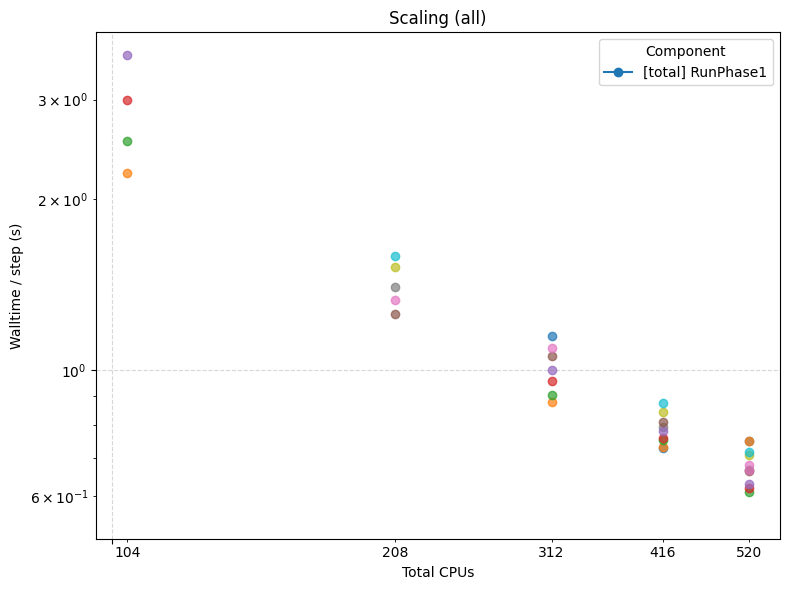


	[total] RunPhase1
__output_name	combine
    cores                                      case   combine
0   104.0    node_1_queue_normalsr_shared_13_ocn_91  2.229278
1   104.0    node_1_queue_normalsr_shared_26_ocn_78  2.534375
2   104.0    node_1_queue_normalsr_shared_39_ocn_65  2.997882
3   104.0    node_1_queue_normalsr_shared_52_ocn_52  3.589109
4   208.0   node_2_queue_normalsr_shared_13_ocn_195  1.254925
5   208.0   node_2_queue_normalsr_shared_26_ocn_182  1.327949
6   208.0   node_2_queue_normalsr_shared_39_ocn_169  1.402763
7   208.0   node_2_queue_normalsr_shared_52_ocn_156  1.517741
8   208.0   node_2_queue_normalsr_shared_65_ocn_143  1.590097
9   312.0  node_3_queue_normalsr_shared_104_ocn_208  1.148501
10  312.0   node_3_queue_normalsr_shared_26_ocn_286  0.877838
11  312.0   node_3_queue_normalsr_shared_39_ocn_273  0.904201
12  312.0   node_3_queue_normalsr_shared_52_ocn_260  0.958191
13  312.0   node_3_queue_normalsr_shared_65_ocn_247  0.998514
14  312.0   node_3_queue_nor

In [24]:
plot_scaling(plot_df, ycol="tmedian", selection="all", mode="scaling", logx=True, logy=True, ref_index=0)

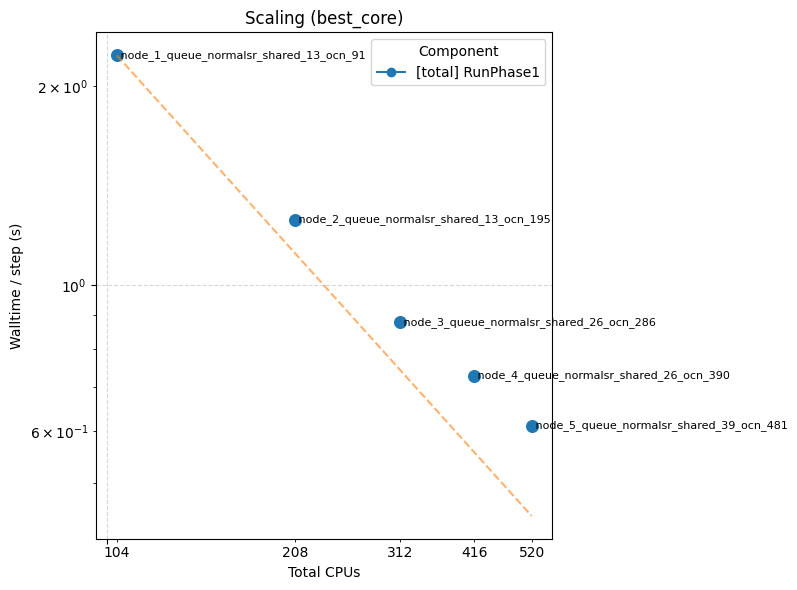


	[total] RunPhase1
__output_name	combine
                                          case   combine
cores                                                   
104.0   node_1_queue_normalsr_shared_13_ocn_91  2.229278
208.0  node_2_queue_normalsr_shared_13_ocn_195  1.254925
312.0  node_3_queue_normalsr_shared_26_ocn_286  0.877838
416.0  node_4_queue_normalsr_shared_26_ocn_390  0.728144
520.0  node_5_queue_normalsr_shared_39_ocn_481  0.610744


In [25]:
plot_scaling(plot_df, ycol="tmedian", selection="best_core", mode="scaling", logx=True, logy=True, show_case_names=True, ref_index=0)

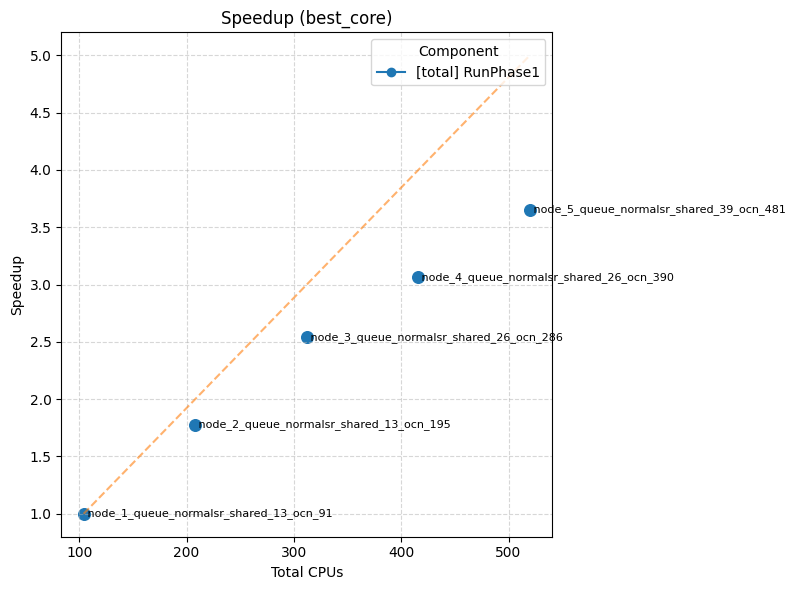


	[total] RunPhase1
__output_name	combine
                                          case   combine
cores                                                   
104.0   node_1_queue_normalsr_shared_13_ocn_91  1.000000
208.0  node_2_queue_normalsr_shared_13_ocn_195  1.776424
312.0  node_3_queue_normalsr_shared_26_ocn_286  2.539509
416.0  node_4_queue_normalsr_shared_26_ocn_390  3.061591
520.0  node_5_queue_normalsr_shared_39_ocn_481  3.650100


In [26]:
plot_scaling(plot_df, ycol="tmedian", selection="best_core", mode="speedup", show_case_names=True, ref_index=0)

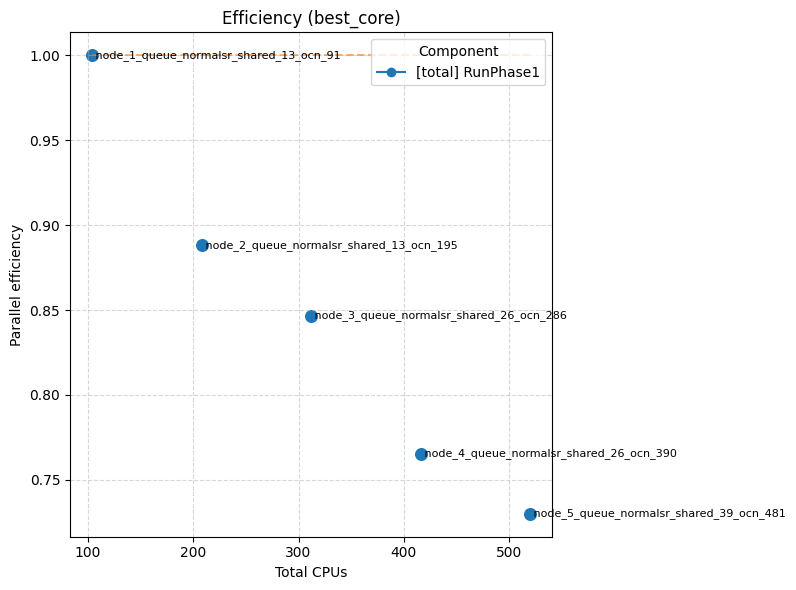


	[total] RunPhase1
__output_name	combine
                                          case   combine
cores                                                   
104.0   node_1_queue_normalsr_shared_13_ocn_91  1.000000
208.0  node_2_queue_normalsr_shared_13_ocn_195  0.888212
312.0  node_3_queue_normalsr_shared_26_ocn_286  0.846503
416.0  node_4_queue_normalsr_shared_26_ocn_390  0.765398
520.0  node_5_queue_normalsr_shared_39_ocn_481  0.730020


In [27]:
plot_scaling(plot_df, ycol="tmedian", selection="best_core", mode="efficiency", show_case_names=True, ref_index=0)